# TSSL Lab 2 - Structural model, Kalman filtering and EM

- Qinyuan QI(qinqi464)

We will continue to work with the Global Mean Sea Level (GMSL) data that we got acquainted with in lab 1. The data is taken from https://climate.nasa.gov/vital-signs/sea-level/ and is available on LISAM in the file `sealevel.csv`.

In this lab we will analyse this data using a structural time series model. We will first set up a model and implement a Kalman filter to infer the latet states of the model, as well doing long-term prediction. We will then implement a disturbance smoother and an expectation maximization algorithm to tune the parameters of the model. 



We load a few packages that are useful for solving this lab assignment.

In [183]:
import pandas  # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)  # Increase default size of plots

## 2.1 Setting up a structural state space model

We start by loading and plotting data to reming ourselves what it looks like.

In [184]:
data=pandas.read_csv('sealevel.csv',header=0)

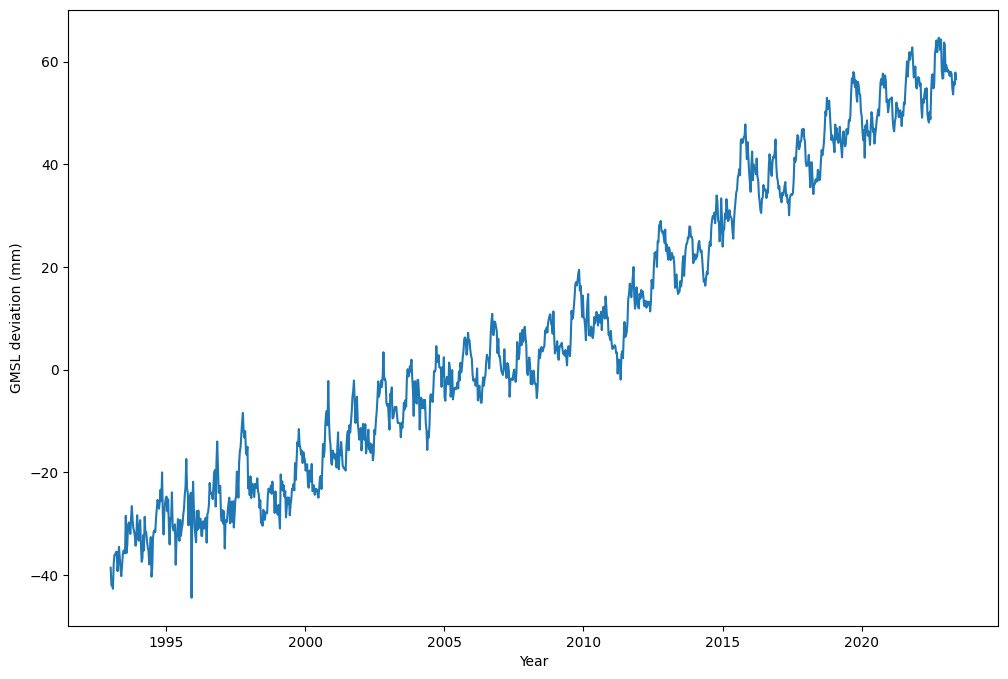

In [185]:
y = data['GMSL'].values
u = data['Year'].values
ndata = len(y)
plt.plot(u,y)
plt.xlabel('Year')
plt.ylabel('GMSL deviation (mm)')
plt.show()

In this lab we will use a structural time series model to analys this data set. Specifically, we assume that the data $\{y_t\}_{t\geq 1}$ is generated by

\begin{align}
    y_t = \mu_t + \gamma_t + \varepsilon_t
\end{align}

where $\mu_t$ is a trend component, $\gamma_t$ is a seasonal component, and $\varepsilon_t$ is an observation noise. The model is expressed using a state space representation,

\begin{align}
    \alpha_{t+1} &= T \alpha_t + R\eta_t, & \eta_t&\sim N(0,Q), \\
    y_t &= Z \alpha_t + \varepsilon_t, & \varepsilon_t&\sim N(0,\sigma_\varepsilon^2).
\end{align}

**Q0:** Let $d = \dim(\alpha_t)$ denote the _state dimension_ and $d_\eta = \dim(\eta_t)$ denote the dimension of the state noise. Then, what are the dimenisons of the matrices $T$, $R$, and $Z$ of the state space model?

**A:**

T is the Transition matrix, from $\alpha_t$ to $\alpha_{t+1}$, so it's dimension is $d \times d$.

R is the Disturbance Matrix, since dimension of $\eta_t$ is $d_{\eta}$, to make the first formula work, it's dimension is $d \times d_\eta$.

Z is the Observation Matrix, it's dimension is $1 \times d$ given $y_t$ is a scale value.

**Q1:** Create the state space matrices $T_{[\mu]}$, $R_{[\mu]}$, and $Z_{[\mu]}$ corresponding to the trend component $\mu_t$. We assume a local linear trend (that is, of order $k=2$). 

_Hint:_ Use **2-dimensional** `numpy.ndarray`s of the correct sizes to represent all the matrices.

In [186]:
from math import comb # for python3.8+

# for local linear trend model, we have k=2(which is the k used in Q0),
# and d_eta=1
k = 2
d_eta = 1

# since most of the data is 0, so we use np.zeros instead of np.ndarray.
T_mu = np.zeros(shape=(k,k))
R_mu = np.zeros(shape=(k,d_eta))
Z_mu = np.zeros(shape=(d_eta,k))

# formula for T_mu is from slide 7 of Lecture 5a,
# first row is c_1 to c_k, ci = (-1)^{i+1} * comb(k,i)
# i should change to i+1 when using python(0-based)
# remaining (second to last row) is a diagonal matrix with 
# 1 on the diag, 0 otherwise
for i in range(k):
    if i == 0:
        for j in range(k):
            T_mu[i,j] = (-1)**(j+2) * comb(k,j+1)
    else:
        T_mu[i,i-1] = 1

R_mu[0,0] = 1 # dim of R_mu 2 * 1
Z_mu[0,0] = 1 # dim of Z_mu 1 * 2

# print out the matrices we just calculated
print("T: \n", T_mu)
print("R: \n", R_mu)
print("Z: \n", Z_mu)

T: 
 [[ 2. -1.]
 [ 1.  0.]]
R: 
 [[1.]
 [0.]]
Z: 
 [[1. 0.]]


**Q2:** There is a yearly seasonal pattern present in the data. What should we set the periodicity $s$ of the seasonal component to, to capture this pattern?

_Hint:_ Count the average number of observations per (whole) year and round to the closest integer.

**A:**

After check the original data, we found that the data is recorded from 1993 and 
end in 2023, and we remove the last 1 row of per_year_count(only 15). 
The remaining data's value are 37 or 36.

After calculate mean value and round to the closest integer, we get 37.

In [187]:
# the original Year data is float type, so we need to get the year number
year = data['Year'].astype(str).str[0:4].astype(int)

# data is ordered by count number of each year
per_year_count = year.value_counts()

# print out the count of each year
print("Per year count: \n", per_year_count)

# remove last 1 row (15) since they are not full years
s = round(np.mean(per_year_count[:-1]))

print("Avg Year count is ", s)

Per year count: 
 Year
1993    37
2018    37
2016    37
2015    37
2019    37
2013    37
2012    37
2011    37
2010    37
2009    37
1994    37
2007    37
2005    37
2004    37
2003    37
2021    37
2001    37
2000    37
1999    37
1998    37
1997    37
2022    37
1995    37
2017    37
2020    36
2008    36
2014    36
2006    36
2002    36
1996    36
2023    15
Name: count, dtype: int64
Avg Year count is  37


**Q3:** What is the _state dimension_ of a seasonal component with periodicity $s$? That is, how many states are needed in the corresponding state space representation?

**A:**

From Q2, we know that the periodicity $s$ is 37.

From slide 8 of Lecture 5b's seasonal component forumula, we know that
the state dimension of a seasonal component with periodicity $s$ is $s-1$, so the state dimension of a seasonal component with periodicity 36 x 36

**Q4:** Create the state space matrices $T_{[\gamma]}$, $R_{[\gamma]}$, and $Z_{[\gamma]}$ corresponding to the seasonal component $\gamma_t$. 

_Hint:_ Use **2-dimensional** `numpy.ndarray`s of the correct sizes to represent all the matrices.

In [188]:
T_gamma = np.zeros(shape=(s-1,s-1))
R_gamma = np.zeros(shape=(s-1,1))
Z_gamma = np.zeros(shape=(1,s-1))

# formula for T_gamma is from slide 8 of Lecture 5b
# all of elements in first row are -1, from second to last row, it is a matrix with
# diagonal value 1 on the diag, 0 otherwise
for i in range(s-1):
    if i == 0:
        T_gamma[i,:] = -1
    else:
        T_gamma[i,i-1] = 1

R_gamma[0,0] = 1
Z_gamma[0,0] = 1

# print out the matrices we just calculated
print("T: \n", T_gamma)
print("R: \n", R_gamma)
print("Z: \n", Z_gamma)

T: 
 [[-1. -1. -1. ... -1. -1. -1.]
 [ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ...  0.  1.  0.]]
R: 
 [[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Z: 
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


**Q5:** Using the matrices that you have constructed above, create the state space matrices for the complete structural time series model. Print out the shapes of the resulting system matrices and check that they correspond to what you expect (cf **Q0**).

_Hint:_ Use `scipy.linalg.block_diag` and `numpy.concatenate`.

**A5**

According to the output below, we find that $d = 38$, and $d_{\eta} = 2$

In [189]:
from scipy.linalg import block_diag

# create the matrix as follows, dimmension will increase
# T_mu       0
#    0 T_gamma

T = block_diag(T_mu, T_gamma)
R = block_diag(R_mu, R_gamma)
Z = np.concatenate((Z_mu, Z_gamma), axis=1) # combine columns

In [190]:
# print out the matrices shape we just calculated
print("Dim of T: ", T.shape)
print("Dim of R: ", R.shape)
print("Dim of Z: ", Z.shape)

Dim of T:  (38, 38)
Dim of R:  (38, 2)
Dim of Z:  (1, 38)


We also need to specify the variances of the process noise $\eta_t$ and measurement noise $\varepsilon_t$. Below, we will estimate (two of) these variances from data, but for now we set them arbitrarily to get an initial model to work with.

In [191]:
# Some arbitrary noise values for now
sigma_trend = 0.01
sigma_seas = 1
sigma_eps = 1
# Process noise covariance matrix
Q = np.array([[sigma_trend**2, 0.], [0., sigma_seas**2]])  

Finally, to complete the model we need to specify the distribution of the initial state. This encodes our _a priori_ belief about the actual values of the trend and seasonality, i.e., before observing any data.

**Q6:** Set up the mean vector of the initial state $a_1 = \mathbb{E}[\alpha_1]$ such that:
* The trend component starts at the first observation, $\mathbb{E}[\mu_1] = y_1$,
* The slope of the trend is _a priori_ zero in expectation, $\mathbb{E}[\mu_1 - \mu_0] = 0$,
* The initial mean of all states related to the seasonal component are zero.

Also, create an initial state covariance matrix $P_1 = \text{Cov}(\alpha_1)$ as an identity matrix of the correct dimension, multiplied with a large value (say, 100) to represent our uncertainty about the initial state.

In [192]:
# define the dimension
# k = 2 , s = 37, defined above(in Q5)
dim_a1 = k + s - 1

# every data point is one dimension
a1 = np.zeros(shape=(dim_a1,1))

# set init value according to the question
# y: data['GMSL'], defined above
a1[0,0] = y[0]
a1[1,0] = y[0]

# create p1 = cov(a1) = identity matrix * 100
P1 = np.identity(dim_a1) * 100

In [193]:
print(a1)

[[-38.61]
 [-38.61]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]]


We have now defined all the matrices etc. that make up the structural state space model. For convenience, we can create an object of the class `LGSS` available in the module `tssltools_lab2` as a container for these quantities.

In [194]:
from tssltools_lab2 import LGSS
model = LGSS(T, R, Q, Z, sigma_eps**2, a1, P1)

help(model.get_params)

Help on method get_params in module tssltools_lab2:

get_params() method of tssltools_lab2.LGSS instance
    Return all model parameters.
    
    T, R, Q, Z, H, a1, P1 = model.get_params()



## 2.2 Kalman filtering for the structural model
Now we have the data and a model available. Next, we will turn our attention to the inference problem, which is a central task when analysing time series data using the state space framework.

State inference is the problem of estimating the unknown (latent) state variables given the data. For the time being we assume that the _model parameters_ are completely specified, according to above, and only consider how to estimate the states using the Kalman filter.

In the questions below we will treat the first $n=800$ time steps as training data and the remaining $m$ observations as validation data. 

In [195]:
n = 800 # training data
m = ndata - n # validation data


**Q7:** Complete the Kalman filter implementation below. The function should be able to handle missing observations, which are encoded as "not a number", i.e. `y[t] = np.nan` for certain time steps `t`. 

_Hint:_ The Kalman filter involves a lot of matrix-matrix and matrix-vector multiplications. It turns out to be convient to store sequences of vectors (such as the predicted and filtered state estimates) as `(d,1,n)` arrays, instead of `(d,n)` or `(n,d)` arrays. In this way the matrix multiplications will result in 2d-arrays of the correct shapes without having to use a lot of explicit `reshape`. However, clearly, this is just a matter of coding style preferences!

In [196]:
from tssltools_lab2 import kfs_res

def kalman_filter(y, model: LGSS):
    """Kalman filter for LGSS model with one-dimensional observation.

    :param y: (n,) array of observations. May contain nan, which encodes missing observations.
    :param model: LGSS object with the model specification.
    
    :return kfs_res: Container class with member variables,
        alpha_pred: (d,1,n) array of predicted state means.
        P_pred: (d,d,n) array of predicted state covariances.
        alpha_filt: (d,1,n) array of filtered state means.
        P_filt: (d,d,n) array of filtered state covariances.
        y_pred: (n,) array of means of p(y_t | y_{1:t-1})
        F_pred: (n,) array of variances of p(y_t | y_{1:t-1})
    """

    n = len(y)
    d = model.d  # State dimension
    alpha_pred = np.zeros((d, 1, n))
    P_pred = np.zeros((d, d, n))
    alpha_filt = np.zeros((d, 1, n))
    P_filt = np.zeros((d, d, n))
    y_pred = np.zeros(n)
    F_pred = np.zeros(n)

    T, R, Q, Z, H, a1, P1 = model.get_params()  # Get all model parameters (for brevity)

    # all the following code use the algorithm from slide 9 of Lecture 5c
    for t in range(n):
        # Time update (predict) 
        # ADD CODE HERE        
        if t == 0:
            # if t=0, then use hat(\alpha_{1|0}) = a1, P_{1|0} = P1
            alpha_pred[:,:,t] = a1
            P_pred[:,:,t] = P1
        else:
            # hat(\alpha_{t|t-1}) = T * hat(\alpha_{t-1|t-1})
            # P_{t|t-1} = T * P_{t-1|t-1} * T^{T} + RQR^{T}
            alpha_pred[:,:,t] = np.dot(T, alpha_filt[:,:,t-1])
            P_pred[:,:,t] = np.dot(T, np.dot(P_filt[:,:,t-1], T.T)) + \
                np.dot(R, np.dot(Q,R.T))
        
        # Compute prediction of current output        
        # hat(\y_{t|t-1}) = Z * hat(\alpha_{t|t-1})
        # F_{t|t-1} = Z * P_{t|t-1} * Z^{T} + sigma(\epsilon)^2
        # we need to .item() to Extract scalar to avoid warning (NumPy 1.25+)
        # H is sigma_eps^2,defined above
        y_pred[t] = np.dot(Z,alpha_pred[:,:,t]).item()  # Extract scalar
        F_pred[t] = (np.dot(Z, np.dot(P_pred[:,:,t], Z.T)) + H).item()  # Extract scalar
        
        # Measurement update      
        if np.isnan(y[t]):
            # handle missing value
            # hat(\alpha_{t|t}) = hat(\alpha_{t|t-1})
            # P_{t|t} = P_{t|t-1}
            alpha_filt[:,:,t] = alpha_pred[:,:,t]
            P_filt[:,:,t] = P_pred[:,:,t]
            
        else:
            # Kalman gain K = P_{t|t-1} Z^{T} * F_{t|t-1}^{-1}
            # hat(\alpha_{t|t}) = hat(\alpha_{t|t-1}) + K * (y_t - hat(\y_{t|t-1}))
            # P_{t|t} = (I - K*Z) * P_{t|t-1})        
            K = np.dot(P_pred[:,:,t], Z.T) / F_pred[t]
            alpha_filt[:,:,t] = alpha_pred[:,:,t] + np.dot(K, (y[t] - y_pred[t]))
            P_filt[:,:,t] = np.dot((np.identity(d) - np.dot(K,Z)) , P_pred[:,:,t])

    kf = kfs_res(alpha_pred, P_pred, alpha_filt, P_filt, y_pred, F_pred)
    return kf


**Q8:** Use the Kalman filter to infer the states of the structural time series applied to the sealevel data. Run the filter on the training data (i.e., first $n=800$ time steps), followed by a long-range prediction of $y_t$ for the remaining time points. 

Generate a plot which shows:
1. The data $y_{1:n+m}$,
2. The one-step predictions $\hat y_{t|t-1} \pm 1$ standard deviation for the training data, i.e., $t = 1,...,n$,
3. The long-range predictions $\hat y_{t|n} \pm 1$ standard deviation for the validation data, i.e., $t= n+1,...,n+m$,
4. A vertical line indicating the switch between training and validation data, using `plt.axvline(x=u[n])`.

_Hint:_ It is enough to call the `kalman_filter` function once. Make use of the missing data functionality!

In [197]:
y_train = y[:n]

# init validation data, we set validation to nan to test our missing data function
y_valid = np.full(m, np.nan)

# combine validation and train data
y_final = np.concatenate((y_train, y_valid))

# kalman filter for LGSS model
# model is defined above
KF = kalman_filter(y = y_final, model = model)


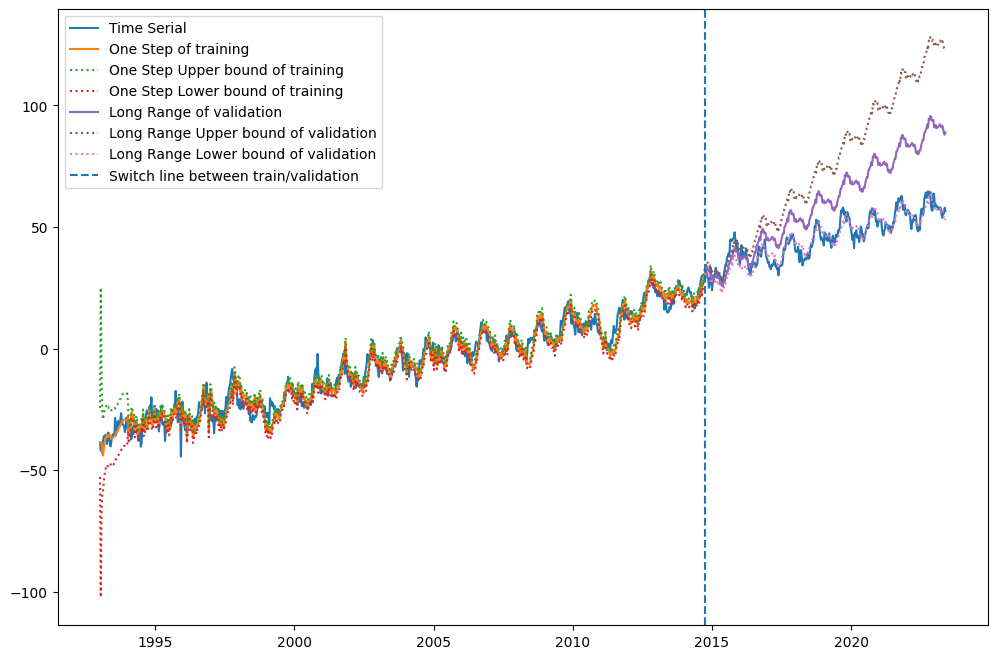

In [198]:
# plot 
# u is YEAR value, y is GSML data
plt.plot(u, y, label = "Time Serial")
# one step prediction on training data 
plt.plot(u[:n],KF.y_pred[:n], label = "One Step of training")
plt.plot(u[:n],KF.y_pred[:n] + np.sqrt(KF.F_pred[:n]), 
         label = "One Step Upper bound of training", ls="dotted")
plt.plot(u[:n],KF.y_pred[:n] - np.sqrt(KF.F_pred[:n]), 
         label = "One Step Lower bound of training", ls="dotted")

# one step prediction on prediction data 
plt.plot(u[n:n+m+1],KF.y_pred[n:n+m+1], label = "Long Range of validation")
plt.plot(u[n:n+m+1], KF.y_pred[n:n+m+1] + np.sqrt(KF.F_pred[n:n+m+1]), 
         label = "Long Range Upper bound of validation", 
         ls="dotted") # line style
plt.plot(u[n:n+m+1], KF.y_pred[n:n+m+1] - np.sqrt(KF.F_pred[n:n+m+1]), 
         label = "Long Range Lower bound of validation", ls="dotted")

# add a vertical line indicating the switch between training and validation data
plt.axvline(x = u[n], label = "Switch line between train/validation",ls="dashed")

plt.legend()
plt.show()

**Q9:** Based on the output of the Kalman filter, compute the training data log-likelihood $\log p(y_{1:n})$.

**A9**:

Log likelihood formula as follows (according to the slide 7 of lecture 6)

$l(\theta) = -\frac{n}{2}log(2\pi) - \frac{1}{2} \sum_{i=1}^{n}(log{F_{t}(\theta)} + \frac{(y_t - \hat{\mu}_{t|t-1}(\theta))^2}  {F_{t}(\theta)})$

In [199]:
# function to calculate log likelihood
def log_likelihood(n, y, y_hat, F):
    log_ll = -0.5 * n * np.log(2 * np.pi) - \
        0.5 * np.sum(np.log(F) + (y-y_hat).T * (y-y_hat) / F) 
    return(log_ll)

# compute the log likelihood on training data
log_ll = log_likelihood(n, y = y_train, y_hat = KF.y_pred[:n], F = KF.F_pred[:n])
print("Training data's log likelihood is ",log_ll)

Training data's log likelihood is  -2986.425560280418


## 2.3 Identifying the noise variances using the EM algorithm
So far we have used fixed model parameters when running the filter. In this section we will see how the model parameters can be learnt from data using the EM algorithm. Specifically, we will try to learn the variance of the state noise affecting the seasonal component as well as the variance of the observation noise,

\begin{align}
    \theta = (\sigma_\gamma^2, \sigma_\varepsilon^2).
\end{align}

For brevity, the variance of the trend component $\sigma_\mu^2$ is fixed to the value $\sigma_\mu^2 = 0.01^2$ as above. (See Appendix A below for an explanation.)

Recall that we consider $y_{1:n}$ as the training data, i.e., we will estimate $\theta$ using only the first $n=800$ observations.

**Q10:** Which optimization problem is it that the EM algorithm is designed to solve? Complete the line below!

**A:** 

According to the slide 12 of lecture 6, we have following formula


$$
\hat\theta = \arg\max_{\theta} \mathbb E \Big[log p_\theta (\alpha_{1:n},y_{1:n}) | y_{1:n}, \tilde{\theta} \Big]
$$

$$
= \arg\max_{\theta} \Big(const. - \frac{1}{2}\sum_{t=1}^{n} \Big[ log|\sigma^2_{\epsilon}| + log|Q| +
$$

$$\left\{ \hat{\epsilon}^2_{t|n} + Var[\epsilon_t | y_{1:n}] \right\} \sigma^{-2}_{\epsilon} + tr \Big[ \left\{ \hat{\eta}_{t|n} \hat{\eta}_{t|n}^T + Var[\eta_t | y_{1:n}]\right\} Q^{-1} \Big] \Big] \Big)
$$

where $\hat{\epsilon}_{t|n}$, $Var[\epsilon_t|y_{1:n}]$, $\hat{\eta}_{t|n}$ and $Var[\eta|y_{1:n}]$ are the smoothed mean and variance of 
$\epsilon_{t}$ and $\eta_{t}$

**Q11:** Write down the updating equations on closed form for the M-step in the EM algorithm.

_Hint: Look at Exercise Session 2_

**A:**

To get the expression to update $\hat{\sigma}^2_{\epsilon}$ and $\hat{\sigma}^2_{\gamma}$, according to the formula provided in Q10, we have

$$
\frac{\partial}{\partial \sigma^2_{\epsilon}} \left( \sum_{t=1}^{n} \left[ \log |\sigma^2_{\epsilon}| + \left(\hat{\epsilon}^2_{t|n} + \text{Var}[\epsilon_t | y_{1:n}] \right) \sigma^{-2}_{\epsilon} \right] \right) = 0
$$

and

$$
\frac{\partial}{\partial Q} \left( \sum_{t=1}^{n} \left[ \log |Q| + \text{tr} \left( \left\{ \hat{\eta}_{t|n} \hat{\eta}_{t|n}^T + \text{Var}[\eta_t | y_{1:n}] \right\} Q^{-1} \right) \right] \right) = 0
$$

then we will have:

$$
\hat{\sigma}^2_{\epsilon} = \frac{1}{n} \sum^n_{t=1} \Big[ \hat{\epsilon}^2_{t|n} + Var[\epsilon_t | y_{1:n}] \Big]
$$

and

$$
\hat{\sigma}^2_{\gamma} = \frac{1}{n} \sum^n_{t=1} \Big[ \hat{\eta}_{t|n} \hat{\eta}_{t|n}^T + Var[\eta_t | y_{1:n}] \Big]
$$

To implement the EM algorithm we need to solve a _smoothing problem_. The Kalman filter that we implemented above is based only on a forward propagation of information. The _smoother_ complements the forward filter with a backward pass to compute refined state estimates. Specifically, the smoothed state estimates comprise the mean and covariances of

\begin{align}
    &p(\alpha_t \mid y_{1:n}), & t=&1,\dots,n
\end{align}

Furthermore, when implementing the EM algorithm it is convenient to work with the (closely related) smoothed estimates of the disturbances, i.e., the state and measurement noise,

\begin{align}
    &p(\eta_t \mid y_{1:n}), & t=&1,\dots,n-1 \\
    &p(\varepsilon_t \mid y_{1:n}), & t=&1,\dots,n
\end{align}

An implementation of a state and disturbance smoother is available in the `tssltools_lab2` module. You may use this when implementing the EM algorithm below.


In [200]:
from tssltools_lab2 import kalman_smoother
help(kalman_smoother)

Help on function kalman_smoother in module tssltools_lab2:

kalman_smoother(y, model: tssltools_lab2.LGSS, kf: tssltools_lab2.kfs_res)
    Kalman (state and disturbance) smoother for LGSS model with one-dimensional observation.
    
    :param y: (n,) array of observations. May contain nan, which encodes missing observations.
    :param model: LGSS object with the model specification.
    :parma kf: kfs_res object with result from a Kalman filter foward pass.
    
    :return kfs_res: Container class. The original Kalman filter result is augmented with the following member variables,
        alpha_sm: (d,1,n) array of smoothed state means.
        V: (d,d,n) array of smoothed state covariances.
        eps_hat: (n,) array of smoothed means of observation disturbances.
        eps_var: (n,) array of smoothed variances of observation disturbances.
        eta_hat: (deta,1,n) array of smoothed means of state disturbances.
        eta_cov: (deta,deta,n) array of smoothed covariances of sta

**Q12:** Implement an EM algorithm by completing the code below. Run the algorithm for 100 iterations and plot the traces of the parameter estimates, i.e., the values $\theta_r$, for $r = 0,\dots,100$.

_Note:_ When running the Kalman filter as part of the EM loop you should only filter the _training data_ (i.e. excluding the prediction for validation data).


In [201]:
# number of iterations for the EM
num_iter = 100

# initial guesses for the noise variance of noise variance of the observation and
# seasonal component
sigma_eps_hat = 1
sigma_seasonal_hat = 1

# estimation array
theta_tilde = np.zeros((num_iter,2))
theta_tilde[0,] = [sigma_seasonal_hat,sigma_eps_hat]

for i in range(1,num_iter):
    # E-step (apply Kalman filter and smoother)

    q_tilde = np.array([[sigma_trend**2, 0.], [0., sigma_seasonal_hat**2]])
    # Define Linear Gaussian State-Space (LGSS) model
    model_em = LGSS(T, R, q_tilde, Z, sigma_eps_hat**2, a1, P1)
    # Run Kalman filter to compute the filtered estimates of the state variables
    # given the observations
    kf_em = kalman_filter(y = y_train, model = model_em)
    # Run The Kalman smoother to the output of the Kalman filter to get the 
    # smoothed estimates
    ks_em = kalman_smoother(y = y_train, model = model_em, kf = kf_em)
    
    # M-step    
    n = len(ks_em.eps_hat)
    # follow the formula in Q11
    sigma_eps_hat = np.sum(ks_em.eps_hat**2 + ks_em.eps_var) / n
    theta_tilde[i,0] = np.sqrt(sigma_eps_hat)
    
    sigma_seasonal_est = 0
    eta_hat_len = ks_em.eta_hat.shape[0]
    # follow the formula in Q11
    for j in range(n):
        eta_smooth = ks_em.eta_hat[:,:,j].dot(ks_em.eta_hat[:,:,j].T) + \
                     ks_em.eta_cov[:,:,j]
        sigma_seasonal_est += eta_smooth[eta_hat_len-1,eta_hat_len-1]
    sigma_seasonal_est = sigma_seasonal_est / n
    theta_tilde[i,1] = np.sqrt(sigma_seasonal_est)
    
    # updated values of sigma_eps_hat and sigma_seas_hat for next loop
    sigma_eps_hat = theta_tilde[i,0]
    sigma_seasonal_hat = theta_tilde[i,1]

In [202]:
print("Sigma_eps_hat: ", sigma_eps_hat)
print("Sigma_seasonal_hat: ", sigma_seasonal_hat)

Sigma_eps_hat:  2.8924886635676543
Sigma_seasonal_hat:  0.19558559811678133


[Text(0.5, 1.0, 'Seasonal Noise Var')]

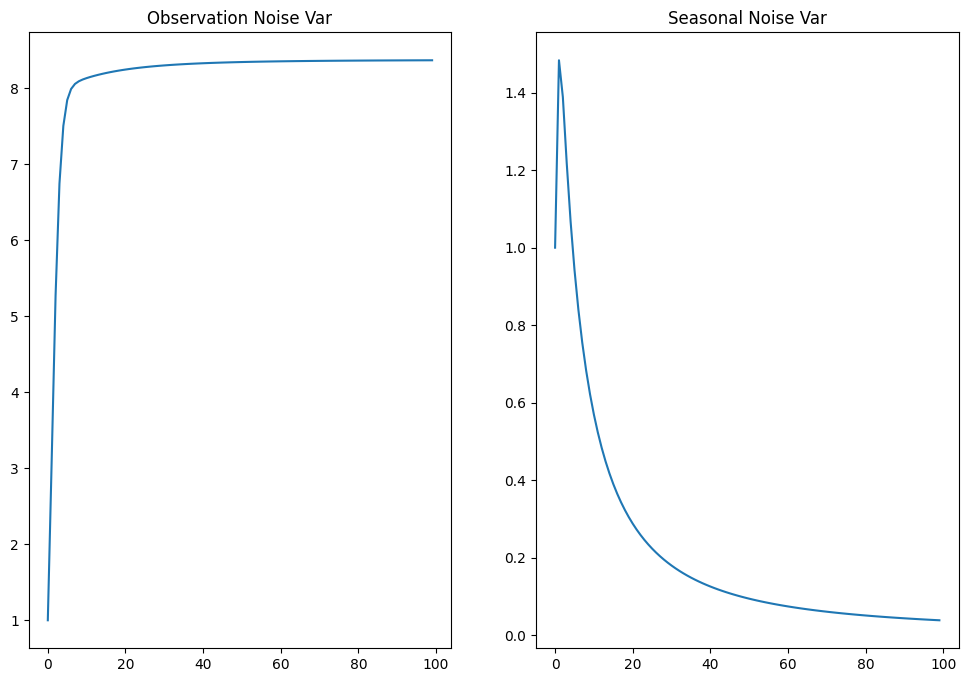

In [203]:
# plot theta_tilde (Observation and Seasonal Noise Var) 
# we need apply square since what we get is sd
fig,ax = plt.subplots(1,2)
ax[0].plot(theta_tilde[:,0]**2)
ax[0].set(title="Observation Noise Var")
ax[1].plot(theta_tilde[:,1]**2)
ax[1].set(title="Seasonal Noise Var")

## 2.4 Further analysing the data
We will now fix the model according to the final output from the EM algorithm and further analyse the data using this model.

**Q13:** Rerun the Kalman filter to compute a _long range prediction for the validation data points,_ analogously to **Q8** (you can copy-paste code from that question). That is, generate a plot which shows:
1. The data $y_{1:n+m}$,
2. The one-step predictions $\hat y_{t|t-1} \pm 1$ standard deviation for the training data, i.e., $t = 1,...,n$,
3. The long-range predictions $\hat y_{t|n} \pm 1$ standard deviation for the validation data, i.e., $t= n+1,...,n+m$,
4. A vertical line indicating the switch between training and validation data, using `plt.axvline(x=u[n])`.

Furthermore, compute the training data log-likelihood $\log p(y_{1:n})$ using the estimated model (cf. **Q9**).

In [204]:
q_final = np.array([[sigma_trend**2, 0.], [0., sigma_seasonal_hat**2]])

# Final model
model_final = LGSS(T, R, q_final, Z, sigma_eps_hat**2, a1, P1)

# Run Kalman filter
kf_final = kalman_filter(y = y_final, model = model_final)

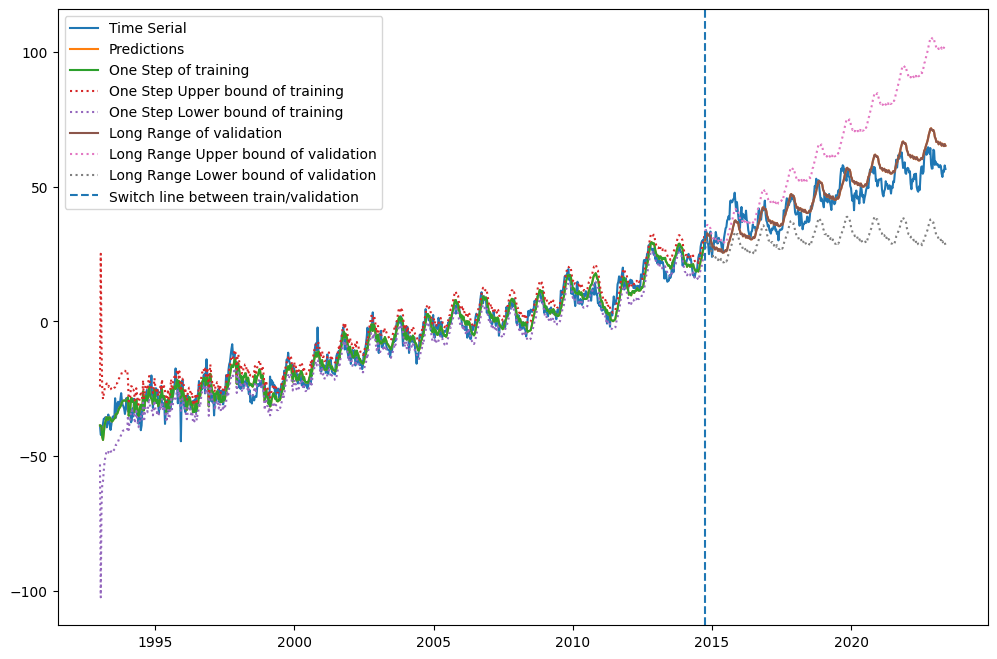

In [205]:
# plot 
plt.plot(u, y, label = "Time Serial")
plt.plot(u, kf_final.y_pred, label = "Predictions")

# one step prediction on training data 
plt.plot(u[:n],kf_final.y_pred[:n], label = "One Step of training")
plt.plot(u[:n],kf_final.y_pred[:n] + np.sqrt(kf_final.F_pred[:n]), 
         label = "One Step Upper bound of training", ls="dotted")
plt.plot(u[:n],kf_final.y_pred[:n] - np.sqrt(kf_final.F_pred[:n]), 
         label = "One Step Lower bound of training", ls="dotted")

# one step prediction on prediction data 
plt.plot(u[n:n+m+1], kf_final.y_pred[n:n+m+1], label = "Long Range of validation") 
plt.plot(u[n:n+m+1], kf_final.y_pred[n:n+m+1] + np.sqrt(kf_final.F_pred[n:n+m+1]), 
         label = "Long Range Upper bound of validation", 
         ls="dotted") # line style
plt.plot(u[n:n+m+1], kf_final.y_pred[n:n+m+1] - np.sqrt(kf_final.F_pred[n:n+m+1]), 
         label = "Long Range Lower bound of validation", ls="dotted")

# add a vertical line indicating the switch between training and validation data
plt.axvline(x = u[n], label = "Switch line between train/validation",ls="dashed")

plt.legend()
plt.show()

In [206]:
# compute the final model's log likelihood on training data
log_ll_final = log_likelihood(n, y = y_train, y_hat = kf_final.y_pred[:n], 
                              F = kf_final.F_pred[:n])
print("Final model's training data's log likelihood is ",log_ll_final)

Final model's training data's log likelihood is  -2147.3334219858425


Note that we can view the model for the data $y_t$ as being comprised of an underlying "signal", $s_t = \mu_t + \gamma_t$ plus observation noise $\varepsilon_t$

\begin{align}
    y_t = s_t + \varepsilon_t
\end{align}

We can obtain refined, _smoothed,_ estimates of this signal by conditioning on all the training data $y_{1:n}$. 

**Q14:** Run a Kalman smoother to compute smoothed estimates of the signal, $\mathbb{E}[s_t | y_{1:n}]$, conditionally on all the _training data_. Then, similarly to above, plot the following:
1. The data $y_{1:n+m}$,
2. The smoothed estimates $\mathbb{E}[s_t | y_{1:n}] \pm 1$ standard deviation for the training data, i.e., $t = 1,...,n$,
3. The predictions $\mathbb{E}[s_t | y_{1:n}] \pm 1$ standard deviation for the validation data, i.e., $t = n+1,...,n+m$,
4. A vertical line indicating the switch between training and validation data, using `plt.axvline(x=u[n])`.

_Hint:_ Express $s_t$ in terms of $\alpha_t$. Based on this expression, compute the smoothed mean and variance of $s_t$ based on the smoothed mean and covariance of $\alpha_t$.

**A:**

We have $s_t = Z \alpha_t$ , so smoothed signal $s_t$ is computed using $\hat{s_t} = Z \hat{\alpha}$

Signal variance is computed using $Var[s_t] = Z V_{\alpha_{t}} Z^T$, and final formula we need is: $Z V_{\alpha_{t}} Z^T + \sigma^2_{\varepsilon}$

In [207]:
# Run Kalman smoother to the output of the Kalman filter to get the 
# smoothed estimates
ks_final = kalman_smoother(y = y_final, model = model_final, kf = kf_final)

# init signal related array
signal = np.zeros(n+m)
signal_val = np.zeros(n+m)

for i in range(n+m):  
    signal[i] = np.dot(model_final.Z, ks_final.alpha_sm[:,:,i]).item()
    signal_val[i] = np.dot(model_final.Z,np.dot(ks_final.V[:,:,i] ,model_final.Z.T)).item() + \
      ks_final.eps_var[i]

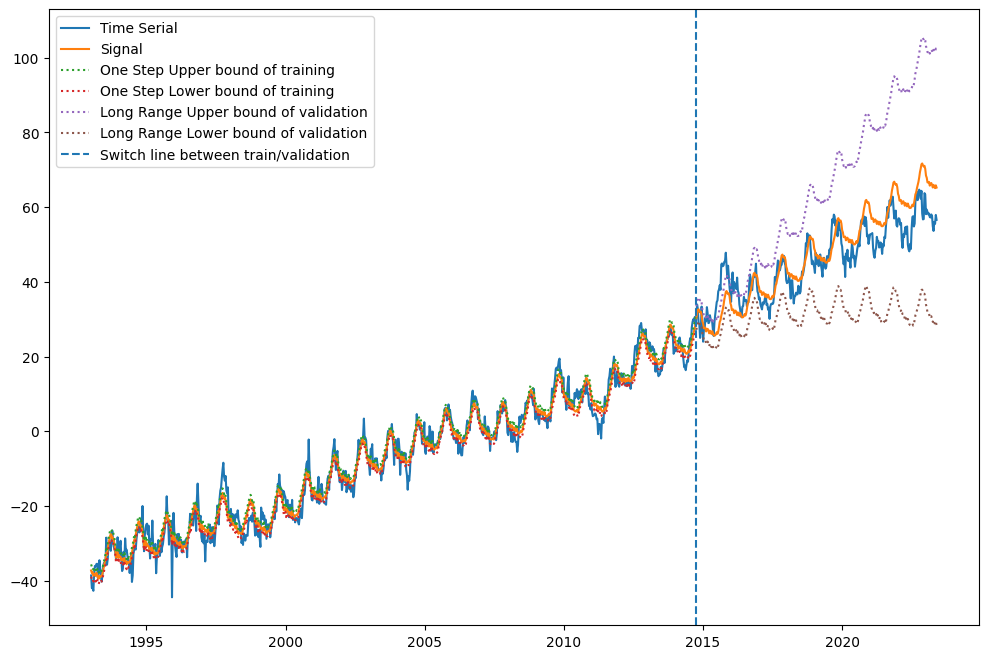

In [208]:
# plot 
plt.plot(u, y, label = "Time Serial")
plt.plot(u, signal, label = "Signal")

# one step prediction on training data 
plt.plot(u[:n],signal[:n] + np.sqrt(signal_val[:n]), 
         label = "One Step Upper bound of training", ls="dotted")
plt.plot(u[:n],signal[:n] - np.sqrt(signal_val[:n]), 
         label = "One Step Lower bound of training", ls="dotted")

# one step prediction on prediction data 
plt.plot(u[n:n+m+1], signal[n:n+m+1] + np.sqrt(signal_val[n:n+m+1]), 
         label = "Long Range Upper bound of validation", 
         ls="dotted") # line style
plt.plot(u[n:n+m+1], signal[n:n+m+1] - np.sqrt(signal_val[n:n+m+1]), 
         label = "Long Range Lower bound of validation", ls="dotted")

# add a vertical line indicating the switch between training and validation data
plt.axvline(x = u[n], label = "Switch line between train/validation",ls="dashed")

plt.legend()
plt.show()

**Q15:** Explain, using a few sentences, the qualitative differences (or similarities) between the Kalman filter predictions plotted in **Q13** and the smoothed signal estimates plotted in **Q14** for,
1. Training data points, $t \leq n$
2. Validation data points, $t > n$

**A:**

Compare plots in Q13 and Q14, we can find that the smoothed signal estimates in Q14 are much closer to the real data than the Kalman filter predictions in Q13 in the Training data area. And the begining of the training data in Q14(smoothed signal estimates) are much closer to the real data than the prediction in Q13.

However, in the validation data area, the prediction in Q13 and Q14 do not have big difference, both of them do not fitting the real data well, and confidence interval range in both plots get bigger when t increase.


We can shed additional light on the properties of the process under study by further decomposing the signal into its trend and seasonal components.

**Q16:** Using the results of the state smoother, compute and plot the _smoothed estimates_ of the two signal components, i.e.:

1. Trend: $\hat \mu_{t|n} = \mathbb{E}[\mu_t | y_{1:n}]$ for $t = 1,\dots,n$
2. Seasonal: $\hat \gamma_{t|n} = \mathbb{E}[\gamma_t | y_{1:n}]$ for $t = 1,\dots,n$

_(You don't have to include confidence intervals here if don't want to, for brevity.)_

In [209]:
# init mu_smooth and gamma_smooth
mu_smooth = np.zeros(n+m)
gamma_smooth = np.zeros(n+m)

for i in range(n+m):  
    mu_smooth[i] = np.dot(Z_mu, ks_final.alpha_sm[:k,:,i]).item()
    gamma_smooth[i] = np.dot(Z_gamma, ks_final.alpha_sm[k:,:,i]).item()

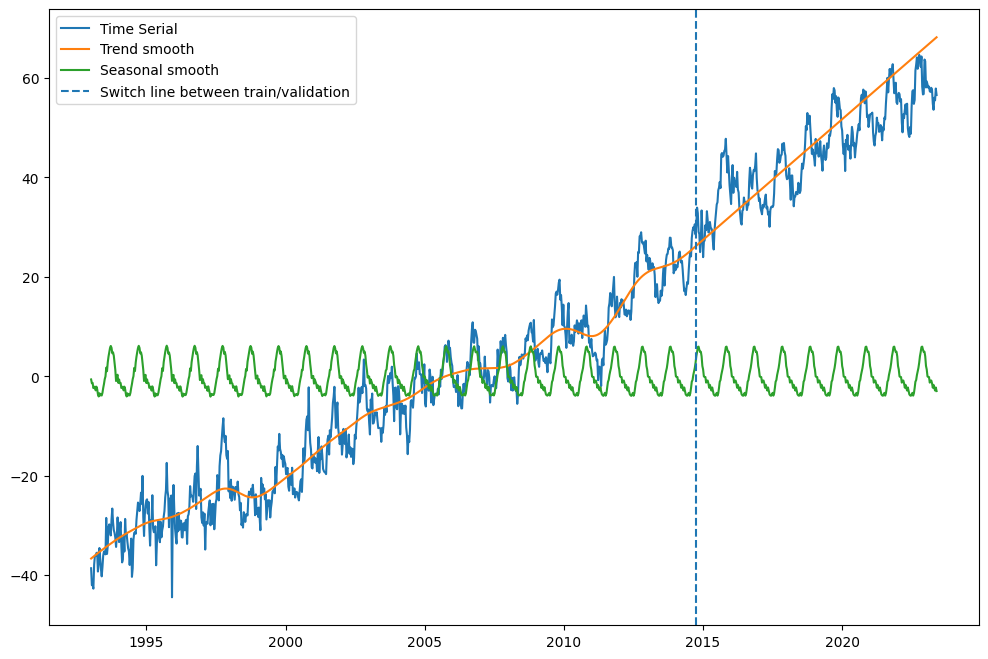

In [210]:
# plot
plt.plot(u, y, label = "Time Serial")
plt.plot(u, mu_smooth, label = "Trend smooth")
plt.plot(u, gamma_smooth, label = "Seasonal smooth")

# add a vertical line indicating the switch between training and validation data
plt.axvline(x = u[n], label = "Switch line between train/validation",ls="dashed")

plt.legend()
plt.show()

## 2.5 Missing data
We conclude this section by illustrating one of the key merits of the state space approach to time series analysis, namely the simplicity of handling missing data. To this end we will assume that a chunk of observations in the middle of the training data is missing.

**Q17:** Let the values $y_{t}$ for $ 300 < t \leq 400$ be missing. Modify the data and rerun the Kalman filter and smoother. Plot,
1. The Kalman filter predictions, analogously to **Q8**
2. The Kalman smoother predictions, analogously to **Q13**

Comment on the qualitative differences between the filter and smoother estimates and explain what you see (in a couple of sentences).

**A:**

Compare with the plots in Q8 and Q13, we found that for missing data, Kalman filter predictions
are much closer to the real data, while in the validation area, both of them do not fitting the real data well.

In [211]:
# set 300-400 null
y_final_missing = y_final
y_final_missing[300:400] = np.nan

kf_missing = kalman_filter(y = y_final_missing, model = model_final)
ks_missing = kalman_smoother(y = y_final_missing, model=model_final,kf=kf_missing)

# init pred 
smooth_pred_missing = np.zeros(n+m)

for i in range(n+m):
  smooth_pred_missing[i] = np.dot(model_final.Z,ks_missing.alpha_sm[:,:,i]).item()

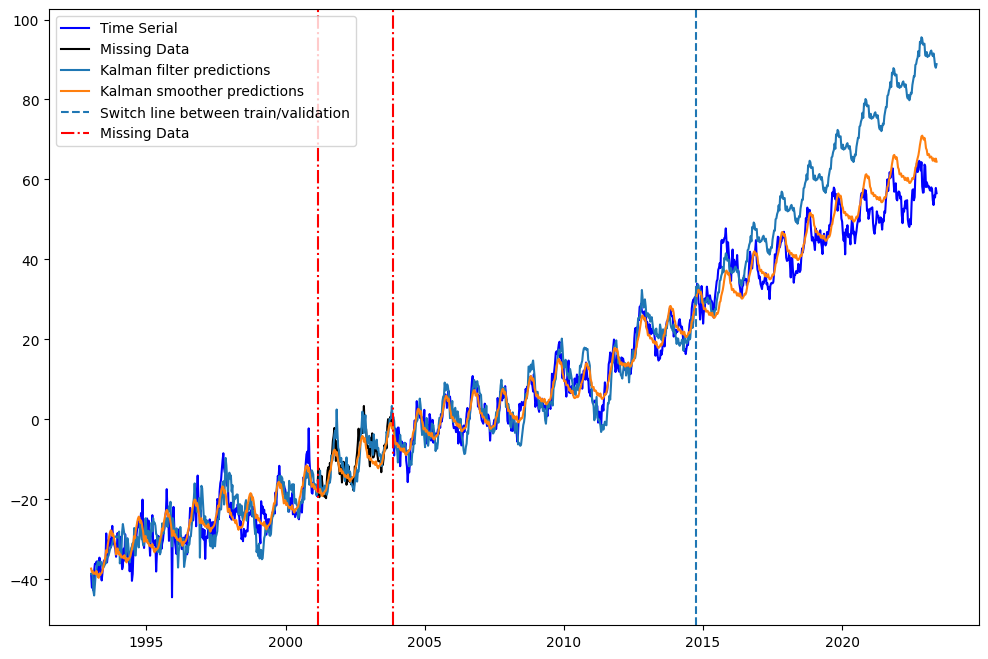

In [212]:
#plot
plt.plot(u[:300], y[:300], label = "Time Serial",color="blue")
plt.plot(u[400:], y[400:], color="blue")

plt.plot(u[300:400], y[300:400],label = "Missing Data",color="black")

plt.plot(u, KF.y_pred, label = "Kalman filter predictions")
plt.plot(u, smooth_pred_missing, label = "Kalman smoother predictions")

# add a vertical switch line
plt.axvline(x = u[n], label = "Switch line between train/validation",ls="dashed")

# add 2 vertical lines to indicating the missing data
plt.axvline(x = u[300], label = "Missing Data",ls="-.",color="red")
plt.axvline(x = u[400],ls="-.",color="red")

plt.legend()
plt.show()


## Appendix A. Why didn't we learn the trend noise variance as well?
In the assignment above we have fixed $\sigma_\mu$ to a small value. Conceptually it would have been straightforward to learn also this parameter with the EM algorithm. However, unfortunately, the maximum likelihood estimate of $\sigma_\mu$ often ends up being too large to result in accurate _long term predictions_. The reason for this issue is that the structural model

\begin{align}
    y_t = \mu_t + \gamma_t + \varepsilon_t
\end{align}

is not a perfect description of reality. As a consequence, when learning the parameters the mismatch between the model and the data is compensated for by increasing the noise variances. This results in a trend component which does not only capture the long term trends of the data, but also seemingly random variations due to a model misspecification, possibly resulting in poor _long range predictions_.

Kitagawa (Introduction to Time Series Modeling, CRC Press, 2010, Section 12.3) discusses this issue and proposes two solutions. The first is a simple and pragmatic one: simply fix $\sigma_\mu^2$ to a value smaller than the maximum likelihood estimate. This is the approach we have taken in this assignment. The issue is of course that in practice it is hard to know what value to pick, which boild down to manual trial and error (or, if you are lucky, the designer of the lab assignment will tell you which value to use!).

The second, more principled, solution proposed by Kitagawa is to augment the model with a stationary AR component as well. That is, we model

\begin{align}
    y_t = \mu_t + \gamma_t + \nu_t + \varepsilon_t
\end{align}

where $\nu_t \sim \text{AR}(p)$. By doing so, the stationary AR component can compensate for the discrepancies between the original structural model and the "true data generating process". It is straightforward to include this new component in the state space representation (how?) and to run the Kalman filter and smoother on the resulting model. Indeed, this is one of the beauties with working with the state space representation of time series data! However, the M-step of the EM algorithm becomes a bit more involved if we want to use the method to estimate also the AR coefficients of the $\nu$-component, which is beyond the scope of this lab assignment.